In [2]:
from scipy.integrate import solve_bvp
import numpy as np
import matplotlib.pyplot as plt
import warnings

def heats(T):
    #heats of reaction and heat capacity calculation from NIST
    t = T/1000

    #CH4
    A =	-0.703029
    B =	108.4773
    C =	-42.52157
    D =	5.862788
    E =	0.678565
    F =	-76.84376
    G =	158.7163
    H =	-74.87310

    dH_CH4 = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_CH4 = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #H2O
    A =   30.09200
    B =   6.832514
    C =   6.793435
    D =  -2.534480
    E =   0.082139
    F =  -250.8810
    G =   223.3967
    H =  -241.8264

    dH_H2O = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_H2O = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #CO
    A =   25.56759
    B =   6.096130
    C =   4.054656
    D =  -2.671301
    E =   0.131021
    F =  -118.0089
    G =   227.3665
    H = -110.5271

    dH_CO = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_CO = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #CO2
    A =   24.99735
    B =   55.18696
    C =  -33.69137
    D =   7.948387
    E =  -0.136638
    F =  -403.6075
    G =   228.2431
    H =  -393.5224

    dH_CO2 = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_CO2 = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #H2
    A =  33.066178
    B = -11.363417
    C =  11.432816
    D = -2.772874
    E = -0.158558
    F = -9.980797
    G =  172.707974
    H =  0.0

    dH_H2 = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_H2 = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #Ar
    A =	20.78600
    B =	2.825911*10**-7
    C =	-1.464191*10**-7
    D =	1.092131*10**-8
    E =	-3.661371*10**-8
    F =	-6.197350
    G =	179.9990
    H =	0

    dH_Ar = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_Ar = A + B*t + C*t**2 + D*t**3 + E/(t**2) #J/mol K

    dHsmr = (3*dH_H2 + dH_CO - dH_CH4 - dH_H2O + 206.1)*10**3 #J/mol
    dHwgs = (dH_H2 + dH_CO2 - dH_CO - dH_H2O - 41.15)*10**3 #J/mol
    # print(dHsmr)
    # print(dHwgs)
    # print([Cp_CH4, Cp_H2O, Cp_CO, Cp_CO2, Cp_H2])
    return dHsmr, dHwgs, [Cp_CH4, Cp_H2O, Cp_CO, Cp_CO2, Cp_H2, Cp_Ar], [dH_CH4, dH_H2O, dH_CO, dH_CO2, dH_H2, dH_Ar]

In [3]:
#reactor constants
L = 0.0609 #m
R_inner = 0.00225 #m outside diameter of inner tube
R_outer = 0.0035 #m inside diameter of outer tube
Rin_outer = 0.003154/2 #m inner radius of inner tube

A = np.pi * ((R_outer)**2-(R_inner)**2) #m^2 AXIAL AREA (GAS FLOW)
V = A*L #m^3
Peri = 2*np.pi*R_outer
S = Peri*L #m^2 RADIAL AREA (HEAT FLUX AND REACTION)

Ain = np.pi * (Rin_outer)**2
Vin = Ain*L
Perimin = 2*np.pi*R_inner
Sinner = Perimin*L

#gas flow constants WHEN CHANGING THE TEMPERATURE YOU NEED TO ADJUST THE INITIAL GUESS -- USING ODEINT MIGHT BE FOR BETTER CONVERSION
Tinfeed = 450 #K
P = 3 #bar or atm
Rgas = 8.3144598 * 10**-5

sccm0 = np.array([16.16, 43.04, 0, 0, 9, 3.49])
mols0 = sccm0/22400 /60
#rate equation constants
Rreact = 8.314 #J / mol·K
Easmr = 165.740 #kJ/mol
Asmr = 1.68*10**8
Eawgs = 89.23 #kJ/mol
Awgs = 9.90*10**3

Ku = 0.2

I = 9 #curent in Amps
Fa = 96485 #faradays constant
h2Rem = 0

Tfurn = 1080 #K 1080
Uouter = 120 #120
Uinner = 104

#q_furn = 3400 #W/m2 K

MM = np.array([16.04, 18.01528, 28.01, 44.009, 2.016, 39.948])
m0 = np.dot(MM, mols0)
print(m0) #kg/s
print(np.sum(mols0))

x_num = 1000
dx = L/(x_num-1)
x_pts = np.linspace(0,L,x_num)

0.0008870138178571427
5.3340773809523796e-05


In [4]:
Tinmem = 1060 #K

Tfeed = np.concatenate((np.linspace(900,1000,int(x_num/20)), np.linspace(1000,1065,int(x_num*4/20)), 
                        np.full(int(x_num*11/20), 1065), np.linspace(1065,1035,int(x_num*2/20)), 
                        np.linspace(1035,1065,int(x_num*2/20))))[::-1]

In [5]:
boundarymem = np.concatenate((mols0, [Tinmem]))
#SHOULD UPDATE THE INITIAL GUESSES TO BE THE OUTCOMES OF THE LAST ONES I JUST NOW REALIZED
init_guess = np.zeros((7, x_num))
init_guess[0, :] = boundarymem[0]
init_guess[1, :] = boundarymem[1]
init_guess[2, :] = boundarymem[2]
init_guess[3, :] = boundarymem[3]
init_guess[4, :] = boundarymem[4]  
init_guess[5, :] = boundarymem[5]

for i in range(15):
    boundarymem = np.concatenate((mols0, [Tinmem]))
    # print(boundarymem)
    init_guess[6, :] = boundarymem[6]

    def odes(x, F):
        F[:6, :][F[:6, :] < 0] = 0
        y = F[:6]/np.sum(F[:6], axis = 0)
        T = F[6]
        Ctot = P/(Rgas * T)

        global vfinalmem
        v = np.sum(F[:6], axis = 0)/Ctot / A #m/sec
        vfinalmem = v

        Keqsmr = (101325/100000)**2 * np.exp(-26830/T + 30.114)
        Keqwgs = np.exp(4400/T - 4.036)

        rsmr = 2*np.pi*R_outer/A*Ku*Asmr*np.exp(-Easmr*1000/Rreact/T)*(y[0]*y[1]-(P**2)*y[2]*(y[4]**3)/Keqsmr)
        rwgs = 2*np.pi*R_outer/A*Ku*Awgs*np.exp(-Eawgs*1000/Rreact/T)*(y[1]*y[2]-y[3]*y[4]/Keqwgs)
        #rh2r = I/(2*Fa*L) #have not confirmed if this is correct
        rsmr[:int(x_num*0.02)] = 0
        rwgs[:int(x_num*0.02)] = 0

        dHsmr, dHwgs, Cps, _ = heats(T)
        Cpg = np.sum(y[:6, :]*Cps, axis=0)

        Fch4 = (-rsmr)*A
        Fh2o = (-rsmr - rwgs)*A
        Fco = (rsmr - rwgs)*A
        Fco2 = (rwgs)*A
        Fh2 = (3*rsmr + rwgs)*A # - h2Rem*rh2r
        Far = np.zeros(len(y[0]))
        Temp = (- A*(dHsmr*rsmr + dHwgs*rwgs) + Peri*Uouter*(-T[:] + Tfurn) +
                Perimin*Uinner*(-T + Tfeed[:len(T)]))/(np.sum(F[:6], axis = 0)*Cpg)

        return np.vstack([Fch4, Fh2o, Fco, Fco2, Fh2, Far, Temp])

    def bcs(yleft, yright):
        return np.array(yleft-boundarymem)

    solnmem = solve_bvp(odes, bcs, x_pts, init_guess, max_nodes=x_num, tol = 0.01)

    Tmem = solnmem.y[6][::-1]

    boundaryfeed = np.concatenate((mols0, [Tinfeed]))
    # print(boundaryfeed)
    init_guess[6, :] = boundaryfeed[6]

    #CAN CHANGE THIS SO THAT IT ONLY DOES TEMPERATURE
    def odes(x, F):
        F[:6, :][F[:6, :] < 0] = 0
        y = F[:6]/np.sum(F[:6], axis = 0)
        T = F[6]
        Ctot = P/(Rgas * T)

        global vfinalfeed
        v = np.sum(F[:6], axis = 0)/Ctot / Ain #m/sec
        vfinalfeed = v

        _, _, Cps, _ = heats(T)
        Cpg = np.sum(y[:6, :]*Cps, axis=0)

        Fch4 = np.zeros(len(y[0]))
        Fh2o = np.zeros(len(y[0]))
        Fco = np.zeros(len(y[0]))
        Fco2 = np.zeros(len(y[0]))
        Fh2 = np.zeros(len(y[0]))
        Far = np.zeros(len(y[0]))
        Temp = Perimin*Uinner*(Tmem[:len(y[0])] - T)/(np.sum(F[:6,], axis = 0)*Cpg)

        return np.vstack([Fch4, Fh2o, Fco, Fco2, Fh2, Far, Temp])

    def bcs(yleft, yright):
        return np.array(yleft-boundaryfeed)

    solnfeed = solve_bvp(odes, bcs, x_pts, init_guess, max_nodes=x_num, tol = 0.0001)

    Tinmem = solnfeed.y[6,-1]
    Tfeed = solnfeed.y[6][::-1]


Text(0.5, 1.0, 'Temperature profile on membrane side')

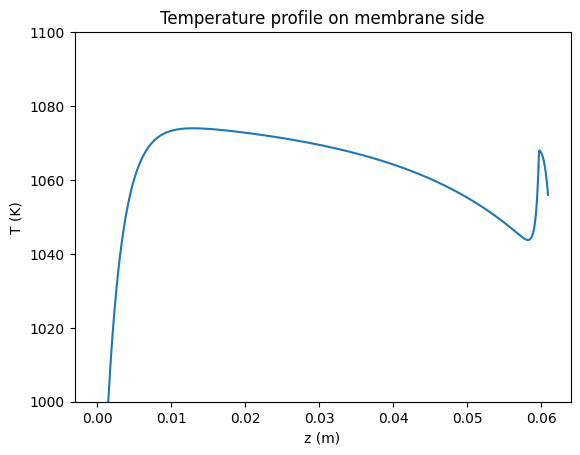

In [6]:
plt.plot(solnmem.x, solnmem.y[6][::-1])
plt.xlabel('z (m)')
plt.ylim(1000,1100)
plt.ylabel('T (K)')
plt.title('Temperature profile on membrane side')

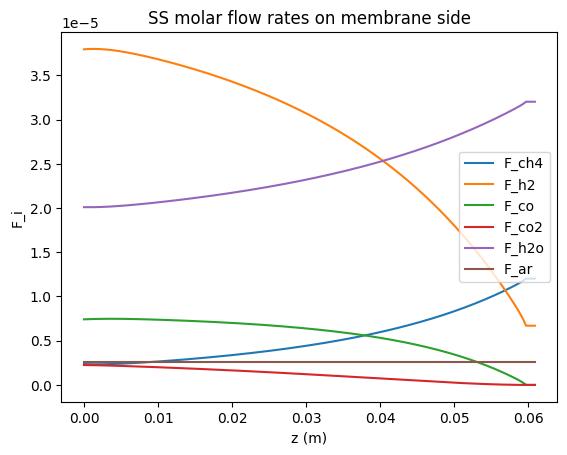

In [7]:
plt.plot(solnmem.x, solnmem.y[0][::-1], label='F_ch4')
plt.plot(solnmem.x, solnmem.y[4][::-1], label='F_h2')
plt.plot(solnmem.x, solnmem.y[2][::-1], label='F_co')
plt.plot(solnmem.x, solnmem.y[3][::-1], label='F_co2')
plt.plot(solnmem.x, solnmem.y[1][::-1], label='F_h2o')
plt.plot(solnmem.x, solnmem.y[5][::-1], label='F_ar')
plt.xlabel('z (m)')
plt.ylabel('F_i')
plt.title('SS molar flow rates on membrane side')
plt.legend()

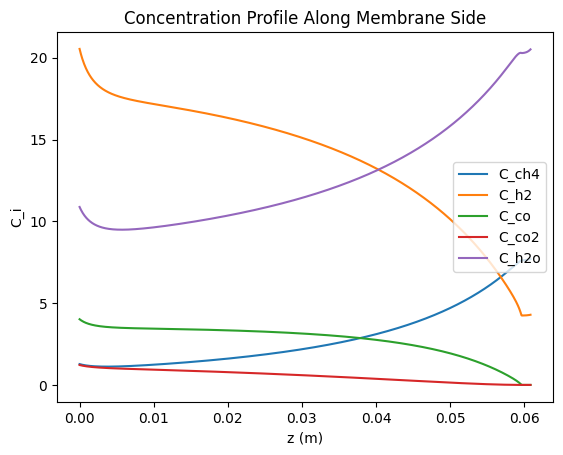

In [8]:
if x_num < 999:
    warnings.warn("x_num is less than 1000!")
v = vfinalmem
concs = solnmem.y[:6,:len(v)]/(v*A)

# print(concs[:,:10])
# print(np.sum(concs[:,:10], axis = 0))
#calculate concentration instead of flow rate

plt.plot(solnmem.x[:len(v)], concs[0][::-1], label='C_ch4')
plt.plot(solnmem.x[:len(v)], concs[4][::-1], label='C_h2')
plt.plot(solnmem.x[:len(v)], concs[2][::-1], label='C_co')
plt.plot(solnmem.x[:len(v)], concs[3][::-1], label='C_co2')
plt.plot(solnmem.x[:len(v)], concs[1][::-1], label='C_h2o')
#plt.plot(solnmem.x, soln.y[5][::-1], label='F_ar')
plt.xlabel('z (m)')
plt.ylabel('C_i')
plt.title('Concentration Profile Along Membrane Side')
plt.legend()

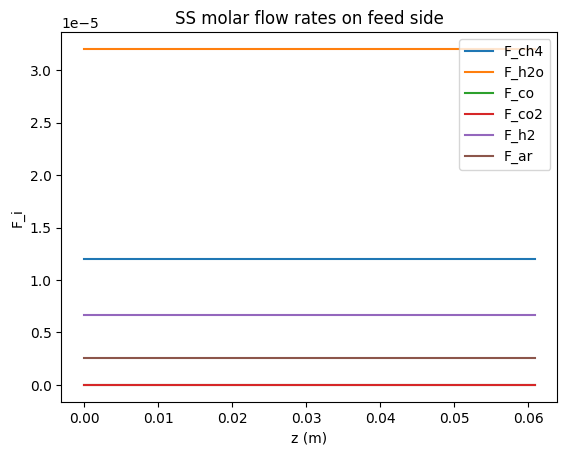

In [9]:
plt.plot(solnfeed.x, solnfeed.y[0], label='F_ch4')
plt.plot(solnfeed.x, solnfeed.y[1], label='F_h2o')
plt.plot(solnfeed.x, solnfeed.y[2], label='F_co')
plt.plot(solnfeed.x, solnfeed.y[3], label='F_co2')
plt.plot(solnfeed.x, solnfeed.y[4], label='F_h2')
plt.plot(solnfeed.x, solnfeed.y[5], label='F_ar')
plt.xlabel('z (m)')
plt.ylabel('F_i')
plt.title('SS molar flow rates on feed side')
plt.legend()

Text(0.5, 1.0, 'Temperature profile on feed side')

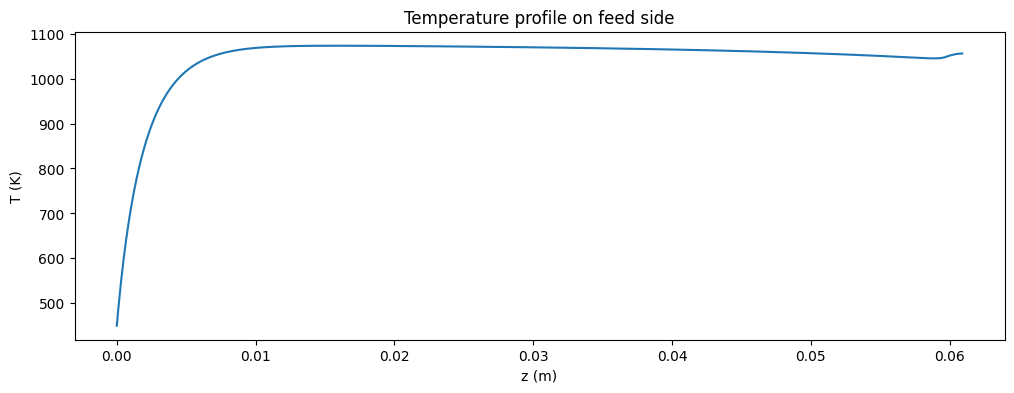

In [10]:
# Tfeedinitial = np.concatenate((np.linspace(450,1000,int(x_num/20)), np.linspace(1000,1065,int(x_num*4/20)), 
                        # np.full(int(x_num*11/20), 1065), np.linspace(1065,1035,int(x_num*2/20)), 
                        # np.linspace(1035,1065,int(x_num*2/20))))
plt.figure(figsize=(12, 4))
plt.plot(solnfeed.x, solnfeed.y[6], label = 'from membrane side calculation')
# plt.plot(solnfeed.x, Tfeedinitial, label = 'CFD estimate')
plt.xlabel('z (m)')
plt.ylabel('T (K)')
plt.title('Temperature profile on feed side')
# plt.legend()
# plt.plot(0.0076, 1000, 'ro') 

In [11]:
mf = np.dot(MM, solnmem.y[:6,-1])

print(f'{m0:.4e}')
print(f'{mf:.4e}')
print(f'mass balance off by {abs(mf - m0)/mf *100:.3e}%')

8.8701e-04
8.8704e-04
mass balance off by 2.894e-03%


In [12]:
#Enthalpy balance based on heats of formation
_, _, _, heatsin = heats(solnfeed.y[6,0])
_, _, _, heatsout = heats(solnmem.y[6,-1])

Qarray = Peri*Uouter*(-solnmem.y[6] + Tfurn)*dx
Q = np.sum(Qarray)
print(Q/S)

#[dH_CH4, dH_H2O, dH_CO, dH_CO2, dH_H2, dH_Ar] # kJ/mol
Hin = np.sum((heatsin + np.array([-74.5, -241.8, -110.5, -393.52, 0, 0]))*10**3 *solnfeed.y[:6,0])
Hout = np.sum((heatsout + np.array([-74.5, -241.8, -110.5, -393.52, 0, 0]))*10**3 *solnmem.y[:6,-1])

dH = Hout-Hin
print(f'{dH:.3} W')
print(f'{Q:.3} W')
print(f'heat balance off by {abs(dH - Q)/Q *100:.4}%')

2319.163070962639
3.07 W
3.11 W
heat balance off by 1.079%


Text(0.5, 1.0, 'Velocity profile along feed side')

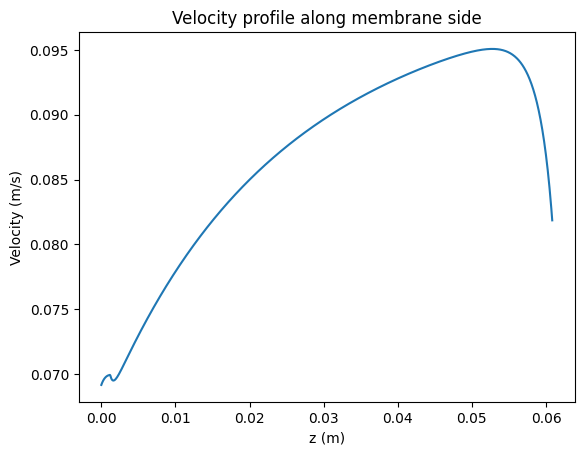

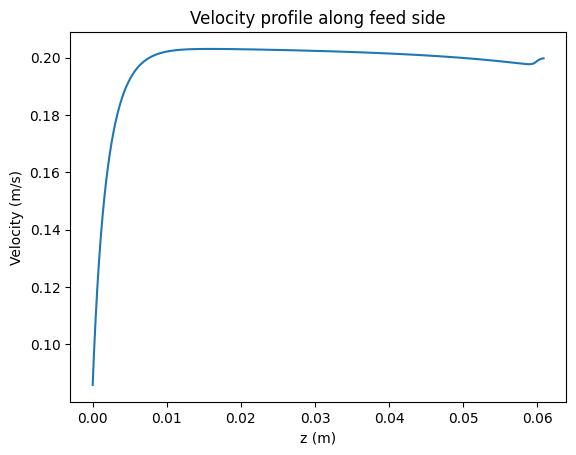

In [13]:
v = vfinalmem
plt.figure()
plt.plot(solnmem.x[:len(v)], v)
plt.xlabel('z (m)')
plt.ylabel('Velocity (m/s)')
plt.title(f'Velocity profile along membrane side')

vfeed = vfinalfeed
plt.figure()
plt.plot(solnmem.x[:len(v)], vfeed)
plt.xlabel('z (m)')
plt.ylabel('Velocity (m/s)')
plt.title(f'Velocity profile along feed side')

88.03090408870912


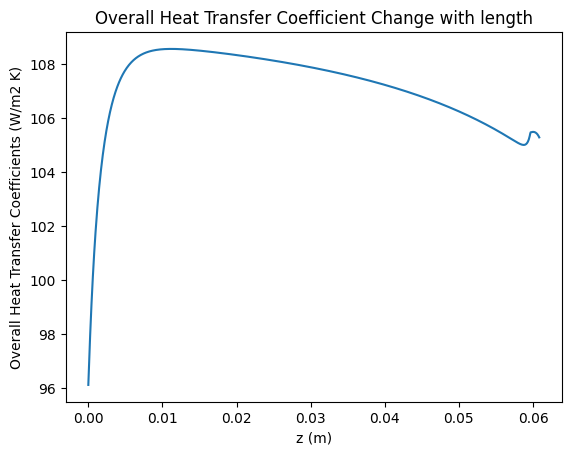

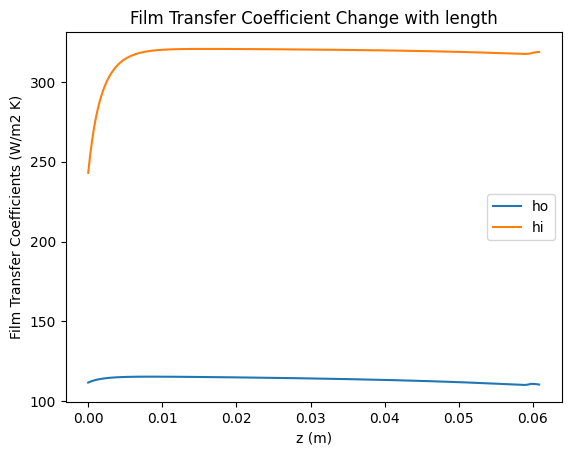

In [14]:
#membrane film conductance/convection heat transfer coefficient
Ctotmem = P/(Rgas * solnmem.y[6])
vmem = vfinalmem
_, _, Cpmem, _ = heats(solnmem.y[6])
ymem = solnmem.y[:6]/np.sum(solnmem.y[:6], axis = 0)
Cpgmem = np.sum(ymem*Cpmem, axis=0)
ho = Ctotmem[:len(vmem)] * Cpgmem[:len(vmem)] * vmem

Ctotfeed = P / (Rgas * solnfeed.y[6])
vfeed = vfinalfeed
_, _, Cpfeed, _ = heats(solnfeed.y[6])
yfeed = solnfeed.y[:6]/np.sum(solnfeed.y[:6], axis = 0)
Cpgfeed = np.sum(yfeed * Cpfeed,axis=0 )
hi = Ctotfeed[:len(vfeed)] * Cpgfeed[:len(vfeed)] * vfeed

invU = 1/hi + Rin_outer/R_inner*1/ho[::-1] + 2*Rin_outer*np.log(R_inner/Rin_outer)/(2*71.8)   #can adjust the nickle convection to change with temp too
U = 1/invU
plt.figure()
plt.plot(solnfeed.x[:len(U)], U)
plt.xlabel('z (m)')
plt.ylabel('Overall Heat Transfer Coefficients (W/m2 K)')
plt.title('Overall Heat Transfer Coefficient Change with length')

plt.figure()
plt.plot(solnfeed.x[:len(ho)], ho[::-1], label='ho')
plt.plot(solnfeed.x[:len(hi)], hi, label='hi')
plt.xlabel('z (m)')
plt.ylabel('Film Transfer Coefficients (W/m2 K)')
plt.title('Film Transfer Coefficient Change with length')
plt.legend()

print(1/(1/110 + Rin_outer/R_inner*1/310 + 2*Rin_outer*np.log(R_inner/Rin_outer)/(2*71.8)))